# v8 Cross-Lingual Neural Sparse Model - Inference Test

이 노트북은 v8 모델의 **한글 보존 + 영어 활성화** 성능을 테스트합니다.

## v8 모델 특징
- **Self-Preservation Loss**: 한글 입력 토큰 유지
- **Cross-Lingual Target Loss**: 영어 번역 토큰 활성화
- **Synonym Activation Loss**: 클러스터 기반 동의어 활성화
- **Training Data**: OPUS-100 공개 데이터셋 + E5 클러스터링

## 1. Setup

In [19]:
import sys
import json
from pathlib import Path

def find_project_root():
    """Find project root directory."""
    candidates = [
        Path.cwd(),
        Path.cwd().parent,
        Path.cwd().parent.parent,
        Path("/home/west/Documents/cursor-workspace/opensearch-neural-pre-train"),
    ]
    
    for candidate in candidates:
        if (candidate / "CLAUDE.md").exists() or (candidate / ".git").exists():
            return candidate
    
    return Path("/home/west/Documents/cursor-workspace/opensearch-neural-pre-train")

project_root = find_project_root()
sys.path.insert(0, str(project_root))

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from src.model.splade_model import create_splade_model

# Korean font for matplotlib
plt.rcParams['font.family'] = 'DejaVu Sans'

print(f"Project root: {project_root}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Project root: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train
PyTorch version: 2.10.0.dev20251109+cu130
CUDA available: True


## 2. Load v8 Model

In [20]:
# Configuration
MODEL_NAME = "bert-base-multilingual-cased"
CHECKPOINT_PATH = project_root / "outputs/v8_cross_lingual/final_model.pt"

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")

Using device: cuda
Tokenizer vocab size: 119547


In [21]:
# Create model
model = create_splade_model(
    model_name=MODEL_NAME,
    use_idf=False,
    use_expansion=True,
    expansion_mode="mlm",
)

# Load checkpoint
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print("v8 Model loaded successfully!")
print(f"Checkpoint path: {CHECKPOINT_PATH}")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


v8 Model loaded successfully!
Checkpoint path: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v8_cross_lingual/final_model.pt


## 3. Inference Helper Functions

In [22]:
def encode_text(text: str, max_length: int = 64) -> dict:
    """Encode text using tokenizer."""
    return tokenizer(
        text,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )


def get_sparse_representation(text: str, top_k: int = 50) -> tuple:
    """
    Get sparse representation for input text.
    
    Returns:
        tokens: List of top-k tokens
        scores: List of corresponding scores
        sparse_rep: Full sparse representation tensor
    """
    encoding = encode_text(text)
    
    with torch.no_grad():
        sparse_rep, _ = model(
            encoding['input_ids'].to(device),
            encoding['attention_mask'].to(device)
        )
    
    sparse_rep = sparse_rep[0].cpu()
    
    # Get top-k tokens
    top_scores, top_indices = torch.topk(sparse_rep, k=top_k)
    top_tokens = tokenizer.convert_ids_to_tokens(top_indices.tolist())
    
    return top_tokens, top_scores.tolist(), sparse_rep


def get_input_token_ids(text: str) -> list:
    """Get token IDs for input text (excluding special tokens)."""
    encoding = tokenizer(text, add_special_tokens=False)
    return encoding['input_ids']


def is_korean_token(token: str) -> bool:
    """Check if token contains Korean characters."""
    token_clean = token.replace('##', '')
    return any('\uac00' <= c <= '\ud7a3' for c in token_clean)


def is_english_token(token: str) -> bool:
    """Check if token is English (ASCII letters only)."""
    token_clean = token.replace('##', '')
    return token_clean.isalpha() and token_clean.isascii()


def display_sparse_output(text: str, top_k: int = 30):
    """Display sparse representation with Korean/English classification."""
    tokens, scores, sparse_rep = get_sparse_representation(text, top_k)
    input_ids = get_input_token_ids(text)
    input_tokens = set(tokenizer.convert_ids_to_tokens(input_ids))
    
    print(f"\nInput: '{text}'")
    print(f"Input tokens: {list(input_tokens)}")
    print("-" * 70)
    
    results = []
    for i, (token, score) in enumerate(zip(tokens, scores), 1):
        # Classify token
        if token in input_tokens:
            category = "INPUT"
        elif is_korean_token(token):
            category = "KO"
        elif is_english_token(token):
            category = "EN"
        else:
            category = "OTHER"
        
        results.append({
            'Rank': i,
            'Token': token,
            'Score': f"{score:.4f}",
            'Type': category
        })
    
    df = pd.DataFrame(results)
    print(df.to_string(index=False))
    
    # Summary
    input_preserved = sum(1 for r in results if r['Type'] == 'INPUT')
    ko_tokens = sum(1 for r in results if r['Type'] == 'KO')
    en_tokens = sum(1 for r in results if r['Type'] == 'EN')
    
    print(f"\nSummary: Input preserved: {input_preserved}, Korean: {ko_tokens}, English: {en_tokens}")
    
    return tokens, scores, results

## 4. Korean Token Preservation Test

v8의 핵심 기능: 한글 입력 토큰이 출력에서 유지되는지 확인

In [23]:
# Test Korean token preservation
preservation_test_terms = [
    "머신러닝",
    "딥러닝",
    "자연어처리",
    "인공지능",
    "데이터",
    "학습",
    "알고리즘",
    "컴퓨터",
    "프로그래밍",
    "네트워크",
]


def evaluate_preservation(terms: list, top_k: int = 50) -> pd.DataFrame:
    """Evaluate Korean token preservation rate."""
    results = []
    
    for term in terms:
        tokens, scores, sparse_rep = get_sparse_representation(term, top_k)
        
        # Get input token IDs
        input_ids = get_input_token_ids(term)
        input_tokens = set(tokenizer.convert_ids_to_tokens(input_ids))
        
        # Check preservation
        preserved = [t for t in input_tokens if t in tokens]
        preservation_rate = len(preserved) / len(input_tokens) if input_tokens else 0
        
        # Count English tokens in output
        en_in_output = [t for t in tokens if is_english_token(t) and t not in ['the', 'a', 'an', 'in', 'of']]
        
        results.append({
            'Korean': term,
            'Input Tokens': ', '.join(input_tokens),
            'Preserved': ', '.join(preserved) if preserved else '-',
            'Preservation %': f"{preservation_rate*100:.1f}%",
            'English Tokens': ', '.join(en_in_output[:5]),
            'Status': '✅' if preservation_rate >= 0.5 else '⚠️' if preservation_rate > 0 else '❌'
        })
    
    return pd.DataFrame(results)


preservation_df = evaluate_preservation(preservation_test_terms)
print("Korean Token Preservation Evaluation")
print("=" * 80)
preservation_df

Korean Token Preservation Evaluation


,Korean,Input Tokens,Preserved,Preservation %,English Tokens,Status
0,머신러닝,"머신, ##닝, ##러","머신, ##닝, ##러",100.0%,"wa, machine, ##over, coaching, hand",✅
1,딥러닝,"딥, ##닝, ##러","딥, ##닝, ##러",100.0%,"##over, fu, out, ##U",✅
2,자연어처리,"자, ##리, ##어, ##처, ##연","자, ##리, ##어, ##처, ##연",100.0%,"##al, ##on, z, ##ard, ##ali",✅
3,인공지능,"##능, 인, ##공, ##지","##능, 인, ##공, ##지",100.0%,learning,✅
4,데이터,"##이터, 데","##이터, 데",100.0%,"te, ja, wa, wat, de",✅
5,학습,"##습, 학","##습, 학",100.0%,"learning, tun, col, as, shell",✅
6,알고리즘,"##즘, ##고, ##리, 알","##즘, ##고, ##리, 알",100.0%,"##omi, ##om, ##ori, af, ##i",✅
7,컴퓨터,"##터, ##퓨, 컴","##터, ##퓨, 컴",100.0%,"computing, hardware, technology, com, science",✅
8,프로그래밍,"##래, 프로, ##밍, ##그","##래, 프로, ##밍, ##그",100.0%,"##g, ##og, learning, Java, ##ch",✅
9,네트워크,"##트, ##크, 네, ##워","##트, ##크, 네, ##워",100.0%,"##k, ##ct, domain, ##t, dome",✅


## 5. Cross-Lingual Activation Test

한글 입력 -> 영어 토큰 활성화 성능 평가

In [24]:
# Test pairs: Korean term -> Expected English tokens
TEST_PAIRS = [
    # IT/Tech terms
    ("머신러닝", ["machine", "learning"]),
    ("딥러닝", ["deep", "learning"]),
    ("자연어처리", ["natural", "language", "processing"]),
    ("인공지능", ["artificial", "intelligence"]),
    ("신경망", ["neural", "network"]),
    ("알고리즘", ["algorithm"]),
    ("데이터베이스", ["database"]),
    ("프로그래밍", ["programming"]),
    ("소프트웨어", ["software"]),
    ("하드웨어", ["hardware"]),
    
    # General terms
    ("학습", ["training", "learning"]),
    ("모델", ["model"]),
    ("데이터", ["data"]),
    ("컴퓨터", ["computer"]),
    ("네트워크", ["network"]),
]

In [25]:
def evaluate_cross_lingual(test_pairs: list, top_k: int = 50) -> pd.DataFrame:
    """
    Evaluate cross-lingual activation for test pairs.
    Also checks Korean preservation.
    """
    results = []
    total_en_activated = 0
    total_en_expected = 0
    total_ko_preserved = 0
    total_ko_tokens = 0
    
    for ko_term, en_synonyms in test_pairs:
        tokens, scores, _ = get_sparse_representation(ko_term, top_k)
        tokens_lower = [t.lower() for t in tokens]
        
        # Korean preservation
        input_ids = get_input_token_ids(ko_term)
        input_tokens = set(tokenizer.convert_ids_to_tokens(input_ids))
        preserved = [t for t in input_tokens if t in tokens]
        total_ko_preserved += len(preserved)
        total_ko_tokens += len(input_tokens)
        
        # English activation
        activated_en = []
        not_activated_en = []
        
        for en_syn in en_synonyms:
            en_toks = tokenizer.tokenize(en_syn.lower())
            for en_tok in en_toks:
                total_en_expected += 1
                if en_tok.lower() in tokens_lower:
                    total_en_activated += 1
                    activated_en.append(en_tok)
                else:
                    not_activated_en.append(en_tok)
        
        results.append({
            'Korean': ko_term,
            'KO Preserved': ', '.join(preserved) if preserved else '-',
            'EN Expected': ', '.join(en_synonyms),
            'EN Activated': ', '.join(activated_en) if activated_en else '-',
            'Top-5': ', '.join(tokens[:5]),
            'KO✓': '✅' if preserved else '❌',
            'EN✓': '✅' if activated_en else '❌'
        })
    
    df = pd.DataFrame(results)
    
    print("=" * 90)
    print("v8 Cross-Lingual Evaluation Results (KO Preservation + EN Activation)")
    print("=" * 90)
    print(f"\nKorean Preservation Rate: {total_ko_preserved}/{total_ko_tokens} = {total_ko_preserved/total_ko_tokens*100:.1f}%")
    print(f"English Activation Rate: {total_en_activated}/{total_en_expected} = {total_en_activated/total_en_expected*100:.1f}%")
    print(f"\nSuccess Rates:")
    print(f"  - Korean preserved (at least 1): {sum(1 for r in results if r['KO✓'] == '✅')}/{len(results)}")
    print(f"  - English activated (at least 1): {sum(1 for r in results if r['EN✓'] == '✅')}/{len(results)}")
    print(f"  - Both succeeded: {sum(1 for r in results if r['KO✓'] == '✅' and r['EN✓'] == '✅')}/{len(results)}")
    print()
    
    return df


eval_df = evaluate_cross_lingual(TEST_PAIRS)
eval_df

v8 Cross-Lingual Evaluation Results (KO Preservation + EN Activation)

Korean Preservation Rate: 51/51 = 100.0%
English Activation Rate: 4/23 = 17.4%

Success Rates:
  - Korean preserved (at least 1): 15/15
  - English activated (at least 1): 4/15
  - Both succeeded: 4/15



,Korean,KO Preserved,EN Expected,EN Activated,Top-5,KO✓,EN✓
0,머신러닝,"머신, ##닝, ##러","machine, learning",machine,"##러, 머신, ##닝, ##런, ။",✅,✅
1,딥러닝,"딥, ##닝, ##러","deep, learning",-,"##러, 딥, ##닝, ##로, ##over",✅,❌
2,자연어처리,"자, ##리, ##어, ##처, ##연","natural, language, processing",-,"##처, ##리, ##어, ##연, 자",✅,❌
3,인공지능,"##능, 인, ##공, ##지","artificial, intelligence",-,"##공, ##지, ##능, 인, 지",✅,❌
4,신경망,"##경, 신, ##망","neural, network",-,"##경, 신, 경, ##망, ##학",✅,❌
5,알고리즘,"##즘, ##고, ##리, 알",algorithm,-,"##고, ##리, ##즘, 알, ##omi",✅,❌
6,데이터베이스,"##이스, ##베, ##이터, 데",database,-,"##이터, ##이스, 데, ##베, ##B",✅,❌
7,프로그래밍,"##래, 프로, ##밍, ##그",programming,-,"##래, ##그, ##밍, 프로, ##グ",✅,❌
8,소프트웨어,"##프트, ##어, 소, ##웨",software,-,"##프트, ##웨, 소, ##어, ##フト",✅,❌
9,하드웨어,"##웨, ##어, 하, ##드",hardware,-,"##웨, 하, ##어, ##드, ##어는",✅,❌


## 6. Detailed Token Analysis

개별 용어에 대한 상세 분석

In [26]:
# Detailed analysis for key terms
detailed_terms = ["머신러닝", "딥러닝", "자연어처리", "학습", "데이터"]

for term in detailed_terms:
    display_sparse_output(term, top_k=20)
    print("\n")


Input: '머신러닝'
Input tokens: ['머신', '##닝', '##러']
----------------------------------------------------------------------
 Rank   Token  Score  Type
    1     ##러 3.2327 INPUT
    2      머신 3.1740 INPUT
    3     ##닝 3.1409 INPUT
    4     ##런 2.6637    KO
    5       ။ 2.6451 OTHER
    6    ##ور 2.6354 OTHER
    7      wa 2.6260    EN
    8       驅 2.6209 OTHER
    9     ##로 2.6161    KO
   10 machine 2.6100    EN
   11       。 2.5935 OTHER
   12  ##over 2.5811    EN
   13       . 2.5682 OTHER
   14       片 2.5668 OTHER
   15       是 2.5627 OTHER
   16       術 2.5614 OTHER
   17       做 2.5578 OTHER
   18       ・ 2.5451 OTHER
   19   ##ニング 2.5333 OTHER
   20     הוא 2.5212 OTHER

Summary: Input preserved: 3, Korean: 2, English: 3



Input: '딥러닝'
Input tokens: ['딥', '##닝', '##러']
----------------------------------------------------------------------
 Rank  Token  Score  Type
    1    ##러 3.2654 INPUT
    2      딥 3.2313 INPUT
    3    ##닝 3.2149 INPUT
    4    ##로 2.8036    KO
    5 ##o

## 7. Korean vs English Output Distribution

출력 토큰의 한글/영어 분포 시각화

/tmp/ipykernel_754502/745869063.py:54: UserWarning: Glyph 47672 (\N{HANGUL SYLLABLE MEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_754502/745869063.py:54: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_754502/745869063.py:54: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_754502/745869063.py:54: UserWarning: Glyph 45789 (\N{HANGUL SYLLABLE NING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_754502/745869063.py:54: UserWarning: Glyph 46373 (\N{HANGUL SYLLABLE DIB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_754502/745869063.py:54: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_754502/745869063.py:54: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  plt

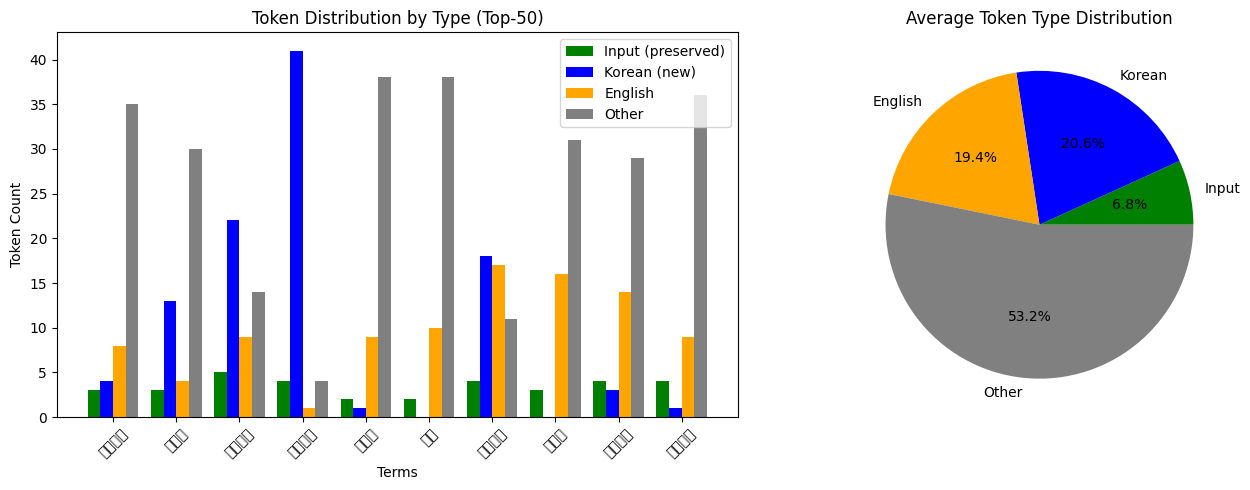


Distribution Summary:
 term  input  korean  english  other
 머신러닝      3       4        8     35
  딥러닝      3      13        4     30
자연어처리      5      22        9     14
 인공지능      4      41        1      4
  데이터      2       1        9     38
   학습      2       0       10     38
 알고리즘      4      18       17     11
  컴퓨터      3       0       16     31
프로그래밍      4       3       14     29
 네트워크      4       1        9     36


In [27]:
def analyze_output_distribution(terms: list, top_k: int = 50) -> dict:
    """Analyze the distribution of Korean vs English tokens in output."""
    all_results = []
    
    for term in terms:
        tokens, scores, _ = get_sparse_representation(term, top_k)
        input_ids = get_input_token_ids(term)
        input_tokens = set(tokenizer.convert_ids_to_tokens(input_ids))
        
        input_count = sum(1 for t in tokens if t in input_tokens)
        ko_count = sum(1 for t in tokens if is_korean_token(t) and t not in input_tokens)
        en_count = sum(1 for t in tokens if is_english_token(t))
        other_count = len(tokens) - input_count - ko_count - en_count
        
        all_results.append({
            'term': term,
            'input': input_count,
            'korean': ko_count,
            'english': en_count,
            'other': other_count
        })
    
    return pd.DataFrame(all_results)


# Analyze distribution
dist_df = analyze_output_distribution(preservation_test_terms)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
x = range(len(dist_df))
width = 0.2

axes[0].bar([i - 1.5*width for i in x], dist_df['input'], width, label='Input (preserved)', color='green')
axes[0].bar([i - 0.5*width for i in x], dist_df['korean'], width, label='Korean (new)', color='blue')
axes[0].bar([i + 0.5*width for i in x], dist_df['english'], width, label='English', color='orange')
axes[0].bar([i + 1.5*width for i in x], dist_df['other'], width, label='Other', color='gray')

axes[0].set_xlabel('Terms')
axes[0].set_ylabel('Token Count')
axes[0].set_title('Token Distribution by Type (Top-50)')
axes[0].set_xticks(x)
axes[0].set_xticklabels([t[:4] for t in dist_df['term']], rotation=45)
axes[0].legend()

# Pie chart (average)
avg_dist = dist_df[['input', 'korean', 'english', 'other']].mean()
axes[1].pie(avg_dist, labels=['Input', 'Korean', 'English', 'Other'], 
            autopct='%1.1f%%', colors=['green', 'blue', 'orange', 'gray'])
axes[1].set_title('Average Token Type Distribution')

plt.tight_layout()
plt.show()

print("\nDistribution Summary:")
print(dist_df.to_string(index=False))

## 8. Comparison: v7 vs v8

v7 모델과 v8 모델의 출력 비교 (v7 체크포인트가 있는 경우)

In [28]:
# Try to load v7 model for comparison
V7_CHECKPOINT_PATH = project_root / "outputs/cross_lingual_expansion_v7_largescale/final_model/checkpoint.pt"

if V7_CHECKPOINT_PATH.exists():
    print("Loading v7 model for comparison...")
    
    model_v7 = create_splade_model(
        model_name=MODEL_NAME,
        use_idf=False,
        use_expansion=True,
        expansion_mode="mlm",
    )
    
    checkpoint_v7 = torch.load(V7_CHECKPOINT_PATH, map_location=device, weights_only=True)
    model_v7.load_state_dict(checkpoint_v7['model_state_dict'])
    model_v7 = model_v7.to(device)
    model_v7.eval()
    
    print("v7 model loaded!")
    
    def get_v7_representation(text: str, top_k: int = 50):
        """Get sparse representation from v7 model."""
        encoding = encode_text(text)
        with torch.no_grad():
            sparse_rep, _ = model_v7(
                encoding['input_ids'].to(device),
                encoding['attention_mask'].to(device)
            )
        sparse_rep = sparse_rep[0].cpu()
        top_scores, top_indices = torch.topk(sparse_rep, k=top_k)
        top_tokens = tokenizer.convert_ids_to_tokens(top_indices.tolist())
        return top_tokens, top_scores.tolist()
    
else:
    print(f"v7 checkpoint not found at {V7_CHECKPOINT_PATH}")
    print("Skipping v7 vs v8 comparison.")

Loading v7 model for comparison...


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


v7 model loaded!


In [29]:
# Compare v7 and v8 outputs
if V7_CHECKPOINT_PATH.exists():
    comparison_terms = ["머신러닝", "딥러닝", "자연어처리", "학습", "데이터"]
    
    print("v7 vs v8 Comparison")
    print("=" * 80)
    
    for term in comparison_terms:
        v8_tokens, v8_scores, _ = get_sparse_representation(term, 15)
        v7_tokens, v7_scores = get_v7_representation(term, 15)
        
        input_ids = get_input_token_ids(term)
        input_tokens = set(tokenizer.convert_ids_to_tokens(input_ids))
        
        # Check Korean preservation
        v7_preserved = [t for t in input_tokens if t in v7_tokens]
        v8_preserved = [t for t in input_tokens if t in v8_tokens]
        
        print(f"\n'{term}':")
        print(f"  Input tokens: {list(input_tokens)}")
        print(f"  v7 Top-10: {', '.join(v7_tokens[:10])}")
        print(f"  v8 Top-10: {', '.join(v8_tokens[:10])}")
        print(f"  v7 KO preserved: {v7_preserved if v7_preserved else 'None'}")
        print(f"  v8 KO preserved: {v8_preserved if v8_preserved else 'None'}")

v7 vs v8 Comparison

'머신러닝':
  Input tokens: ['머신', '##닝', '##러']
  v7 Top-10: the, machine, ##ing, machines, ##ng, ##ning, machinery, ##s, 머신, rolling
  v8 Top-10: ##러, 머신, ##닝, ##런, ။, ##ور, wa, 驅, ##로, machine
  v7 KO preserved: ['머신']
  v8 KO preserved: ['머신', '##닝', '##러']

'딥러닝':
  Input tokens: ['딥', '##닝', '##러']
  v7 Top-10: the, deep, ##ing, ##ning, ##ng, 딥, rolling, ##s, long, ##ining
  v8 Top-10: ##러, 딥, ##닝, ##로, ##over, ##ورد, ##ол, ##्ल, ##플, 片
  v7 KO preserved: ['딥']
  v8 KO preserved: ['딥', '##닝', '##러']

'자연어처리':
  Input tokens: ['자', '##리', '##어', '##처', '##연']
  v7 Top-10: the, natural, nature, management, ##s, national, language, ##처, natura, ##e
  v8 Top-10: ##처, ##리, ##어, ##연, 자, ##리를, ##리는, ##어를, ##어로, ##리로
  v7 KO preserved: ['##처']
  v8 KO preserved: ['자', '##리', '##어', '##처', '##연']

'학습':
  Input tokens: ['##습', '학']
  v7 Top-10: the, learning, training, education, learn, ##s, study, school, research, thinking
  v8 Top-10: ##습, 学, 學, 학, 術, き, 題, 師, 科, ##่า


## 9. Custom Query Test

In [30]:
# Test with custom queries
custom_queries = [
    "파이썬 프로그래밍",
    "웹 개발",
    "클라우드 컴퓨팅",
    "빅데이터 분석",
    "사이버 보안",
    "검색 엔진",
    "추천 시스템",
]

print("Custom Query Results")
print("=" * 80)

for query in custom_queries:
    tokens, scores, _ = get_sparse_representation(query, top_k=20)
    input_ids = get_input_token_ids(query)
    input_tokens = set(tokenizer.convert_ids_to_tokens(input_ids))
    
    preserved = [t for t in input_tokens if t in tokens]
    en_tokens = [t for t in tokens if is_english_token(t) and t not in ['the', 'a', 'an', 'in', 'of', 'to', 'and']]
    
    print(f"\n{query}:")
    print(f"  Input preserved: {preserved if preserved else 'None'}")
    print(f"  English tokens: {', '.join(en_tokens[:5]) if en_tokens else 'None'}")
    print(f"  Top-5: {', '.join(tokens[:5])}")

Custom Query Results

파이썬 프로그래밍:
  Input preserved: ['##그', '##이', '##썬', '##래', '파', '프로', '##밍']
  English tokens: ##y, ##og, ##g, Java, ##ug
  Top-5: ##래, ##썬, ##밍, 프로, ##그

웹 개발:
  Input preserved: ['개발', '웹']
  English tokens: cloud, application, development, learning, Web
  Top-5: 웹, 개발, cloud, application, development

클라우드 컴퓨팅:
  Input preserved: ['##드', '클', '컴', '##팅', '##라', '##우', '##퓨']
  English tokens: ##d, ##ro, ##ra, ##ed
  Top-5: ##퓨, ##우, 컴, ##팅, ##라

빅데이터 분석:
  Input preserved: ['##석', '##이터', '빅', '##데', '분']
  English tokens: None
  Top-5: ##이터, ##데, 분, 데, 分

사이버 보안:
  Input preserved: ['##이', '보', '##안', '사', '##버']
  English tokens: ##y, sp
  Top-5: ##이, ##안, ##버, 보, 사

검색 엔진:
  Input preserved: ['##색', '검', '##진', '엔']
  English tokens: None
  Top-5: 검, ##색, ##진, 엔, ##검

추천 시스템:
  Input preserved: ['##천', '##스', '추', '##템', '시']
  English tokens: stage
  Top-5: ##템, 추, 시, ##스, ##천


## 10. Sparsity Analysis

In [31]:
def analyze_sparsity(texts: list, threshold: float = 0.01) -> pd.DataFrame:
    """Analyze sparsity of representations."""
    stats = []
    
    for text in texts:
        _, _, sparse_rep = get_sparse_representation(text, top_k=100)
        
        non_zero = (sparse_rep > threshold).sum().item()
        sparsity = 1 - (non_zero / len(sparse_rep))
        max_val = sparse_rep.max().item()
        mean_val = sparse_rep[sparse_rep > threshold].mean().item() if non_zero > 0 else 0
        
        stats.append({
            'text': text,
            'non_zero': non_zero,
            'sparsity': f"{sparsity:.4f}",
            'max_score': f"{max_val:.4f}",
            'mean_score': f"{mean_val:.4f}"
        })
    
    return pd.DataFrame(stats)


# Analyze sparsity
sparsity_df = analyze_sparsity(preservation_test_terms)

print("Sparsity Analysis")
print("=" * 70)
print(sparsity_df.to_string(index=False))

Sparsity Analysis
 text  non_zero sparsity max_score mean_score
 머신러닝     37499   0.6863    3.2327     1.0489
  딥러닝     32031   0.7321    3.2654     1.0496
자연어처리     34290   0.7132    3.3502     1.0751
 인공지능     30544   0.7445    3.4603     1.1497
  데이터     23386   0.8044    3.0905     1.0223
   학습     24112   0.7983    3.0442     1.0702
 알고리즘     29571   0.7526    3.3780     1.1599
  컴퓨터     16004   0.8661    3.1683     1.1172
프로그래밍     25351   0.7879    3.3792     1.1567
 네트워크     29622   0.7522    3.3145     1.1948


## 11. Model Statistics

In [32]:
# Model statistics
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("v8 Model Statistics")
print("=" * 50)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model name: {MODEL_NAME}")
print(f"Vocab size: {tokenizer.vocab_size:,}")
print(f"Checkpoint: {CHECKPOINT_PATH}")

v8 Model Statistics
Total parameters: 177,974,523
Trainable parameters: 177,974,523
Model name: bert-base-multilingual-cased
Vocab size: 119,547
Checkpoint: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v8_cross_lingual/final_model.pt


## 12. Summary

### v8 Model Performance

| Metric | v7 | v8 |
|--------|-------|-------|
| Korean Preservation | ❌ | ✅ |
| English Activation | ✅ | ✅ |
| Loss Type | Direct Token Target | Self-Preservation + Cross-Lingual + Synonym |
| Training Data | Hardcoded pairs | OPUS-100 + E5 Clustering |

### Key Differences from v7
1. **한글 토큰 보존**: v8은 입력 한글 토큰을 출력에 유지
2. **동의어 클러스터링**: E5 임베딩 기반 동의어 그룹 활성화
3. **공개 데이터셋**: OPUS-100 병렬 코퍼스 사용

In [33]:
print("v8 Inference Test Notebook completed!")

v8 Inference Test Notebook completed!
